In [36]:
# Standard Libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
from sklearn.model_selection import ParameterGrid

# Darts functions
from darts.timeseries import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel

In [2]:
import torch
print(torch.__version__)  # Should be ~2.0.0 or later

2.8.0+cu126


## **Loading the Data**

In [3]:
prod_df = pd.read_csv("Deep Learning for Time Series Forecasting/TFT/data/vm/production_final_Q42024_df.csv")
prod_df

,well_id,well_name,production_date,well_status,production_status,longitude,latitude,horizontal_length,artificial_lift,area,...,cum_oil_bbl,cum_gas_mscf,cum_water_bbl,cum_eff_prod_day,oil_month_bpd,water_month_bpd,gas_month_mscf_d,gor_month_scf_stb,wor_month_bbl_bbl,proppant_volume_lbm
0,42933,MDM-2,2010-03-01,Active,Producing,-68.623938,-38.232326,0.0,BM,BAJADA_DEL_PALO_OESTE,...,150.96,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,NaN
1,42933,MDM-2,2014-09-01,Active,Producing,-68.623938,-38.232326,0.0,BM,BAJADA_DEL_PALO_OESTE,...,5241.40,12095.63,2223.18,21.4,167.28,73.06,397.49,2376.15,0.44,NaN
2,42933,MDM-2,2014-10-01,Active,Producing,-68.623938,-38.232326,0.0,BM,BAJADA_DEL_PALO_OESTE,...,10357.12,23843.41,3580.67,50.5,168.11,44.61,386.06,2296.41,0.27,NaN
3,42933,MDM-2,2014-11-01,Active,Producing,-68.623938,-38.232326,0.0,BM,BAJADA_DEL_PALO_OESTE,...,13924.06,30091.63,4503.32,80.1,117.22,30.32,205.33,1751.70,0.26,NaN
4,42933,MDM-2,2014-12-01,Active,Producing,-68.623938,-38.232326,0.0,BM,BAJADA_DEL_PALO_OESTE,...,16913.58,32767.07,4978.56,111.1,98.24,15.62,87.92,894.94,0.16,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125734,166151,CoN.x-3(h),2024-11-01,Active,Producing,-68.248902,-38.445605,3000.0,SN,CONFLUENCIA_NORTE,...,36408.30,5609.58,13695.77,43.9,1032.50,208.22,158.97,153.96,0.20,NaN
125735,166151,CoN.x-3(h),2024-12-01,Active,Producing,-68.248902,-38.445605,3000.0,SN,CONFLUENCIA_NORTE,...,70957.76,11547.40,18681.33,74.8,1135.37,163.84,195.13,171.86,0.14,NaN
125736,166156,CASE-523(h),2024-12-01,Active,Producing,-68.365311,-38.311381,3250.0,SN,COIRON_AMARGO_SUR_ESTE,...,339.05,116.80,9862.06,14.2,11.14,324.09,3.84,344.49,29.09,NaN
125737,166158,CASE-521(h),2024-12-01,Active,Producing,-68.365437,-38.311382,3250.0,SN,COIRON_AMARGO_SUR_ESTE,...,385.59,141.30,10894.20,14.2,12.67,358.01,4.64,366.45,28.25,NaN


## **Data Type Conversion**

### Converting to datetime

In [4]:
# Convert to datetime without strftime
prod_df['production_date'] = pd.to_datetime(prod_df['production_date'])

In [5]:
prod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125739 entries, 0 to 125738
Data columns (total 36 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   well_id              125739 non-null  int64         
 1   well_name            125739 non-null  object        
 2   production_date      125739 non-null  datetime64[ns]
 3   well_status          125739 non-null  object        
 4   production_status    125739 non-null  object        
 5   longitude            125739 non-null  float64       
 6   latitude             125739 non-null  float64       
 7   horizontal_length    125443 non-null  float64       
 8   artificial_lift      125739 non-null  object        
 9   area                 125739 non-null  object        
 10  operator             125739 non-null  object        
 11  well_type            125739 non-null  object        
 12  produced_fluid       125739 non-null  object        
 13  fluid_type    

In [6]:
# Filter the dataframe to include only rows where the 'unique_id' is "DE"
af5h_prod = prod_df[prod_df['well_name'] == "AF-5(h)"]


In [36]:
af5h_prod.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64 entries, 90590 to 90653
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   well_id              64 non-null     int64         
 1   well_name            64 non-null     object        
 2   production_date      64 non-null     datetime64[ns]
 3   well_status          64 non-null     object        
 4   production_status    64 non-null     object        
 5   longitude            64 non-null     float64       
 6   latitude             64 non-null     float64       
 7   horizontal_length    64 non-null     float64       
 8   artificial_lift      64 non-null     object        
 9   area                 64 non-null     object        
 10  operator             64 non-null     object        
 11  well_type            64 non-null     object        
 12  produced_fluid       64 non-null     object        
 13  fluid_type           64 non-null   

In [7]:
# Set as index
af5h_prod.set_index("production_date", inplace=True)
af5h_prod

,well_id,well_name,well_status,production_status,longitude,latitude,horizontal_length,artificial_lift,area,operator,...,cum_oil_bbl,cum_gas_mscf,cum_water_bbl,cum_eff_prod_day,oil_month_bpd,water_month_bpd,gas_month_mscf_d,gor_month_scf_stb,wor_month_bbl_bbl,proppant_volume_lbm
production_date,,,,,,,,,,,,,,,,,,,,,
2019-08-01,160886,AF-5(h),Active,Producing,-68.708199,-38.084953,2500.0,SN,AGUADA_FEDERAL,VISTA,...,2648.14,1133.30,1837.00,8.0,87.02,60.37,37.24,427.96,0.69,19676233.5
2019-09-01,160886,AF-5(h),Active,Producing,-68.708199,-38.084953,2500.0,SN,AGUADA_FEDERAL,VISTA,...,23165.38,12911.50,9523.00,38.0,674.24,252.58,387.06,574.06,0.37,19676233.5
2019-10-01,160886,AF-5(h),Active,Producing,-68.708199,-38.084953,2500.0,SN,AGUADA_FEDERAL,VISTA,...,51417.64,28546.71,18236.00,69.0,928.43,286.33,513.81,553.41,0.31,19676233.5
2019-11-01,160886,AF-5(h),Active,Producing,-68.708199,-38.084953,2500.0,SN,AGUADA_FEDERAL,VISTA,...,77249.64,42411.95,24721.00,99.0,848.90,213.11,455.64,536.75,0.25,19676233.5
2019-12-01,160886,AF-5(h),Active,Producing,-68.708199,-38.084953,2500.0,SN,AGUADA_FEDERAL,VISTA,...,103927.68,58009.05,30584.05,130.0,876.70,192.67,512.56,584.64,0.22,19676233.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,160886,AF-5(h),Active,Producing,-68.708199,-38.084953,2500.0,SN,AGUADA_FEDERAL,VISTA,...,859511.98,586665.39,235724.31,1749.7,265.33,82.30,139.72,526.61,0.31,19676233.5
2024-09-01,160886,AF-5(h),Active,Producing,-68.708199,-38.084953,2500.0,SN,AGUADA_FEDERAL,VISTA,...,866491.07,591455.08,239137.89,1779.6,229.35,112.18,157.40,686.29,0.49,19676233.5
2024-10-01,160886,AF-5(h),Active,Producing,-68.708199,-38.084953,2500.0,SN,AGUADA_FEDERAL,VISTA,...,873005.24,595799.46,241643.64,1810.6,214.07,82.34,142.77,666.91,0.38,19676233.5


In [8]:
# Assume af5h_prod has a 'well_id' column and a datetime index
af5h_prod.index = pd.to_datetime(af5h_prod.index)
af5h_prod = af5h_prod.asfreq('MS')  # Ensure monthly frequency

In [9]:
# Identify numerical columns
numerical_cols = af5h_prod.select_dtypes(include=['int64', 'float64']).columns
print("Numerical columns:", numerical_cols)

Numerical columns: Index(['well_id', 'longitude', 'latitude', 'horizontal_length', 'campaign',
       'number_of_stages', 'fluid_volume_m3', 'cum180_oil_bbl',
       'cum180_gas_mscf', 'eur_oil_mbbl', 'eur_gas_mmscf', 'eur_total_mboeq',
       'oil_month_bbl', 'gas_month_mscf', 'water_month_bbl', 'eff_prod_day',
       'cum_oil_bbl', 'cum_gas_mscf', 'cum_water_bbl', 'cum_eff_prod_day',
       'oil_month_bpd', 'water_month_bpd', 'gas_month_mscf_d',
       'gor_month_scf_stb', 'wor_month_bbl_bbl', 'proppant_volume_lbm'],
      dtype='object')


In [10]:
numerical_cols = ['oil_month_bbl', 'gas_month_mscf', 'water_month_bbl', 'cum_oil_bbl', 'cum_gas_mscf', 'cum_water_bbl','oil_month_bpd', 'water_month_bpd', 'gas_month_mscf_d',]

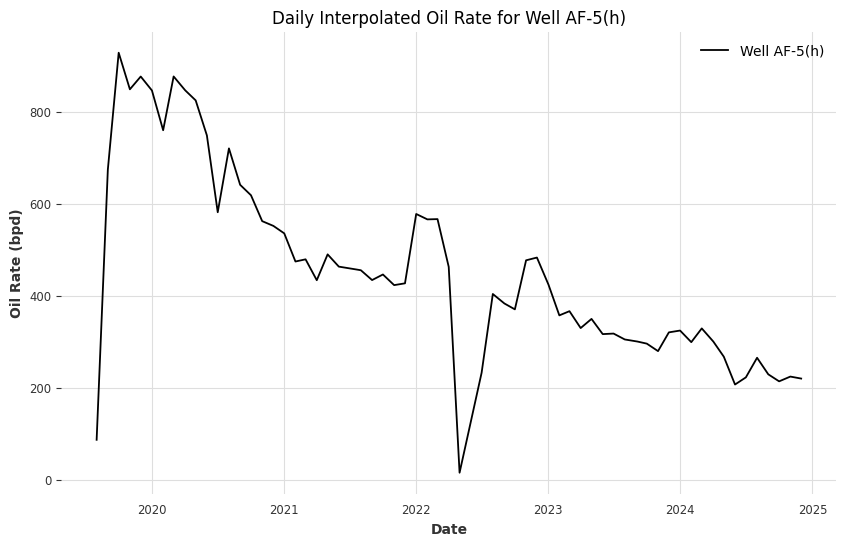

In [12]:
# Group by well_id and resample/interpolate all numerical columns
daily_data_by_well = {}
for well_name, group in af5h_prod.groupby('well_name'):
    # Select only numerical columns for interpolation
    numerical_group = group[numerical_cols]
    
    # Resample to daily and interpolate numerical columns
    daily_data = numerical_group.resample('D').interpolate(method='linear')
    
    # Merge back with non-numerical columns (e.g., forward-fill categorical data)
    non_numerical_cols = group.drop(columns=numerical_cols).columns
    if not non_numerical_cols.empty:
        non_numerical_data = group[non_numerical_cols].resample('D').ffill()  # Forward-fill categorical data
        daily_data = pd.concat([daily_data, non_numerical_data], axis=1)
    
    # Store the result
    daily_data_by_well[well_name] = daily_data

    # Plot to verify (e.g., for oil_month_bpd)
    plt.figure(figsize=(10, 6))
    if 'oil_month_bpd' in daily_data.columns:
        plt.plot(daily_data.index, daily_data['oil_month_bpd'], label=f'Well {well_name}')
        plt.title(f'Daily Interpolated Oil Rate for Well {well_name}')
        plt.xlabel('Date')
        plt.ylabel('Oil Rate (bpd)')
        plt.legend()
        plt.show()

In [ ]:
# Access daily data for a specific well (e.g., first well)
df_well_daily = daily_data_by_well[list(daily_data_by_well.keys())[0]]

                 oil_month_bbl  gas_month_mscf  water_month_bbl  cum_oil_bbl  \
production_date                                                                
2019-08-01         2648.140000     1133.300000      1837.000000  2648.140000   
2019-08-02         3224.562581     1476.683871      2025.677419  3309.986452   
2019-08-03         3800.985161     1820.067742      2214.354839  3971.832903   
2019-08-04         4377.407742     2163.451613      2403.032258  4633.679355   
2019-08-05         4953.830323     2506.835484      2591.709677  5295.525806   

                 cum_gas_mscf  cum_water_bbl  oil_month_bpd  water_month_bpd  \
production_date                                                                
2019-08-01        1133.300000    1837.000000      87.020000        60.370000   
2019-08-02        1513.241935    2084.935484     105.962581        66.570323   
2019-08-03        1893.183871    2332.870968     124.905161        72.770645   
2019-08-04        2273.125806    2580.8

In [15]:
df_well_daily

,oil_month_bbl,gas_month_mscf,water_month_bbl,cum_oil_bbl,cum_gas_mscf,cum_water_bbl,oil_month_bpd,water_month_bpd,gas_month_mscf_d,well_id,...,cum180_oil_bbl,cum180_gas_mscf,eur_oil_mbbl,eur_gas_mmscf,eur_total_mboeq,eff_prod_day,cum_eff_prod_day,gor_month_scf_stb,wor_month_bbl_bbl,proppant_volume_lbm
production_date,,,,,,,,,,,,,,,,,,,,,
2019-08-01,2648.140000,1133.300000,1837.000000,2648.140000,1133.300000,1837.000000,87.020000,60.370000,37.240000,160886.0,...,144833.08,82703.85,1455.0,1070.0,1633.0,8.0,8.0,427.96,0.69,19676233.5
2019-08-02,3224.562581,1476.683871,2025.677419,3309.986452,1513.241935,2084.935484,105.962581,66.570323,48.524516,160886.0,...,144833.08,82703.85,1455.0,1070.0,1633.0,8.0,8.0,427.96,0.69,19676233.5
2019-08-03,3800.985161,1820.067742,2214.354839,3971.832903,1893.183871,2332.870968,124.905161,72.770645,59.809032,160886.0,...,144833.08,82703.85,1455.0,1070.0,1633.0,8.0,8.0,427.96,0.69,19676233.5
2019-08-04,4377.407742,2163.451613,2403.032258,4633.679355,2273.125806,2580.806452,143.847742,78.970968,71.093548,160886.0,...,144833.08,82703.85,1455.0,1070.0,1633.0,8.0,8.0,427.96,0.69,19676233.5
2019-08-05,4953.830323,2506.835484,2591.709677,5295.525806,2653.067742,2828.741935,162.790323,85.171290,82.378065,160886.0,...,144833.08,82703.85,1455.0,1070.0,1633.0,8.0,8.0,427.96,0.69,19676233.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-27,6716.151333,5357.088667,1746.795333,885640.759333,605161.320000,245619.900667,220.706000,57.404667,176.047333,160886.0,...,144833.08,82703.85,1455.0,1070.0,1633.0,30.0,1840.6,676.55,0.38,19676233.5
2024-11-28,6711.771000,5385.404000,1715.039000,885864.047000,605343.665000,245673.893000,220.562000,56.361000,176.978000,160886.0,...,144833.08,82703.85,1455.0,1070.0,1633.0,30.0,1840.6,676.55,0.38,19676233.5
2024-11-29,6707.390667,5413.719333,1683.282667,886087.334667,605526.010000,245727.885333,220.418000,55.317333,177.908667,160886.0,...,144833.08,82703.85,1455.0,1070.0,1633.0,30.0,1840.6,676.55,0.38,19676233.5


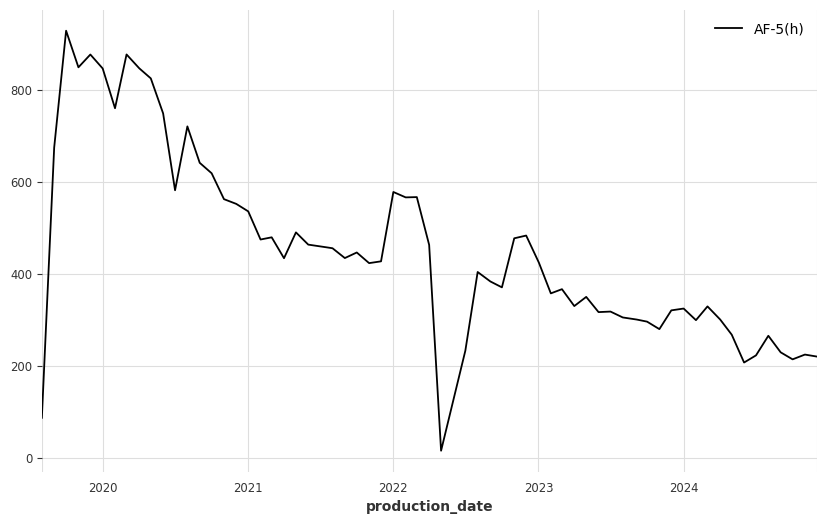

In [16]:
# Visualize the data for each unique ids
# we can see that the date range are not equal
# 3 groups - (BE, FR), DE, (NP, PJM)
plt.rcParams["figure.figsize"] = (10,6)
for id in df_well_daily['well_name'].unique():
  df_well_daily[df_well_daily['well_name'] == id]['oil_month_bpd'].plot(label=id)

plt.legend();

In [ ]:
# Ensure the index is a datetime index with frequency
#af5h_prod.index = pd.to_datetime(af5h_prod.index)
#af5h_prod.index.freq = "MS"  # Explicitly set the frequency

In [19]:
# Set the frequency of the time series data to monthly start and fill missing dates
df_well_daily = df_well_daily.asfreq("D", fill_value=None)  # Use fill_value=None to avoid forward fill

# Exploratory Data Analysis

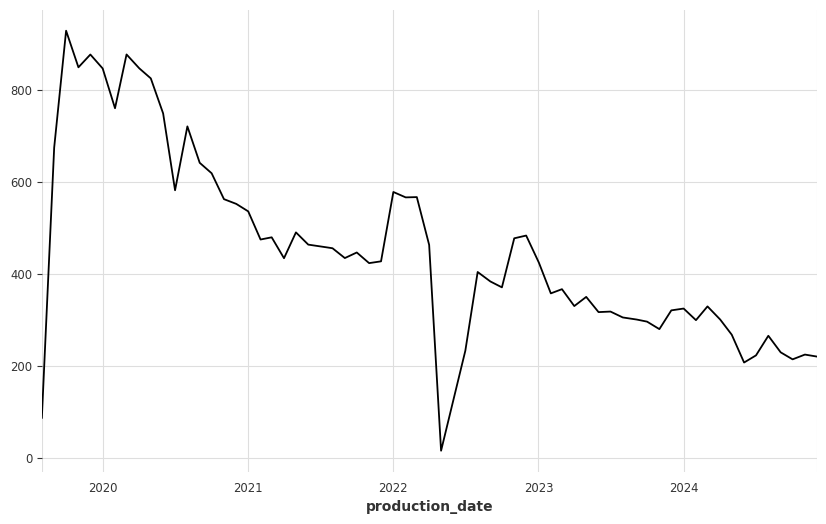

In [20]:
# Plot to verify
df_well_daily['oil_month_bpd'].plot()
plt.show()

In [21]:
df_well_daily['oil_month_bpd'].isna().sum()

np.int64(0)

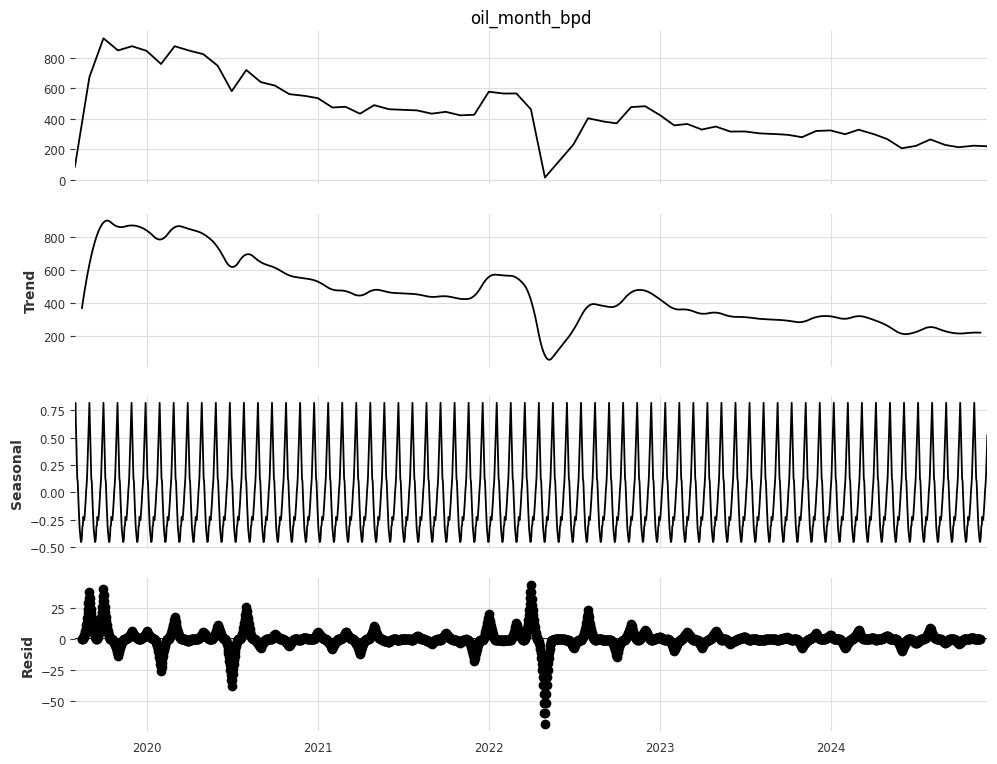

In [22]:
# Perform seasonal decomposition of the electricity price data using an additive model
decomposition = seasonal_decompose(df_well_daily['oil_month_bpd'],
                                   model = 'add',
                                   period = 30)

# Plot the decomposed components (trend, seasonal, and residual)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

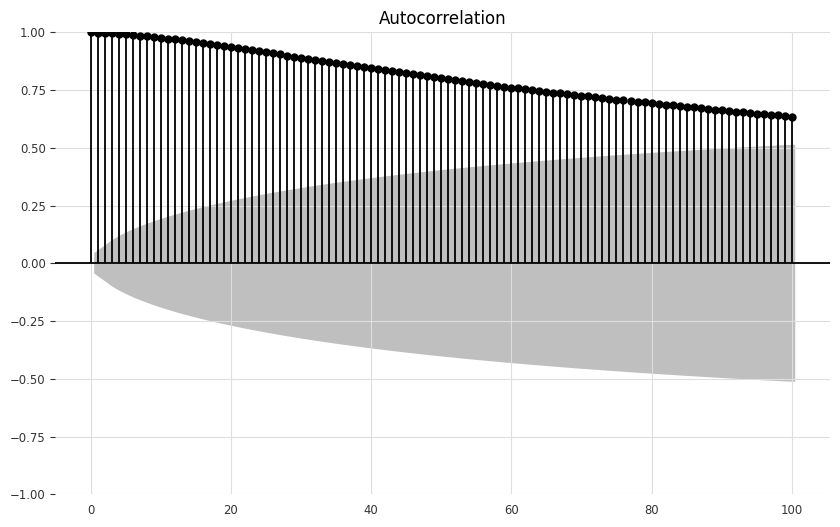

In [23]:
# Plot the autocorrelation function (ACF) for the time series data
fig, ax = plt.subplots(figsize = (10,6))
plot_acf(df_well_daily['oil_month_bpd'], lags = 100, ax = ax)  # Generate the ACF plot with 100 lags
plt.show()

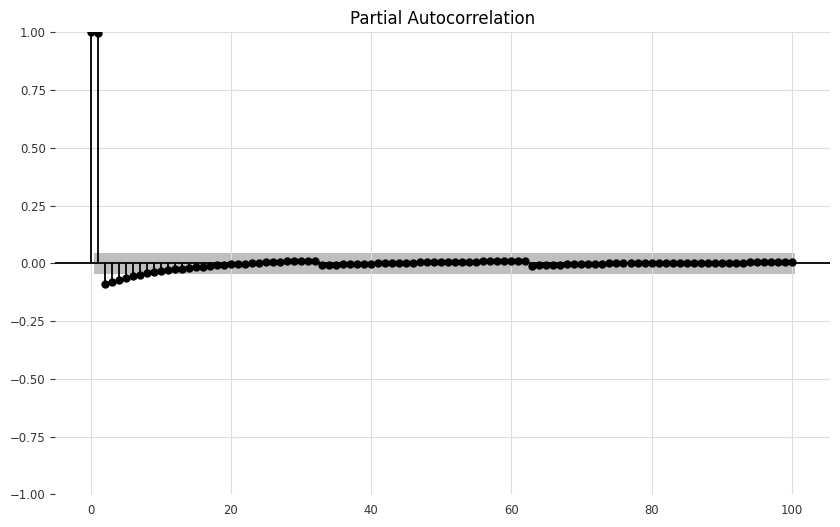

In [24]:
# Plot the partial autocorrelation function (PACF) for the time series data
fig, ax = plt.subplots(figsize = (10,6))
plot_pacf(df_well_daily['oil_month_bpd'], lags = 100, ax = ax)  # Generate the PACF plot with 100 lags
plt.show()

# Time Series, Time, Static Variables

In [25]:
from darts.dataprocessing.transformers import StaticCovariatesTransformer
from darts.timeseries import TimeSeries

static_cols = ['horizontal_length', 
               #'area', 
               'longitude', 'latitude', 
               #'operator', 'well_type', 'fluid_type', 
               'campaign', 'number_of_stages', 'fluid_volume_m3', 'proppant_volume_lbm']

static_covs = df_well_daily[static_cols].iloc[0:1]

In [ ]:
# Prepare a TimeSeries object from the dataframe
series = TimeSeries.from_dataframe(
        df_well_daily,
        value_cols="oil_month_bpd", 
        static_covariates = static_covs,
        fill_missing_dates=True,
        freq="D"
        )

series

<TimeSeries (production_date: 1950, component: 1, sample: 1)> Size: 16kB
array([[[ 87.02      ]],

       [[105.96258065]],

       [[124.90516129]],

       ...,

       [[220.418     ]],

       [[220.274     ]],

       [[220.13      ]]], shape=(1950, 1, 1))
Coordinates:
  * production_date  (production_date) datetime64[ns] 16kB 2019-08-01 ... 202...
  * component        (component) object 8B 'oil_month_bpd'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [27]:
# Function to encode the year as a normalized value
def encode_year(idx):
  return (idx.year - 2000) / 50

# Set up the add_encoders dictionary to specify how different time-related encoders and transformers should be applied
add_encoders = {
    'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week','month']},
    'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week','month']},
    'position': {'past': ['relative'], 'future': ['relative']},
    'custom': {'past': [encode_year], 'future': [encode_year]},
    'transformer': Scaler(),
    'tz': 'CET'
}

# Past Covariates

In [28]:
# Isolating the Past Covariates
past_covariates = ['gas_month_mscf', 'water_month_bbl', 'water_month_bpd', 'gas_month_mscf_d']

X_past = df_well_daily.loc[:,past_covariates]
# Convert the isolated past covariates into a TimeSeries object
past_covariates = TimeSeries.from_dataframe(
                        X_past,
                        fill_missing_dates=True,
                        freq="D"
                        )
# Display
past_covariates

<TimeSeries (production_date: 1950, component: 4, sample: 1)> Size: 62kB
array([[[1133.3       ],
        [1837.        ],
        [  60.37      ],
        [  37.24      ]],

       [[1476.68387097],
        [2025.67741935],
        [  66.57032258],
        [  48.52451613]],

       [[1820.06774194],
        [2214.35483871],
        [  72.77064516],
        [  59.80903226]],

       ...,

       [[5413.71933333],
        [1683.28266667],
        [  55.31733333],
        [ 177.90866667]],

       [[5442.03466667],
        [1651.52633333],
        [  54.27366667],
        [ 178.83933333]],

       [[5470.35      ],
        [1619.77      ],
        [  53.23      ],
        [ 179.77      ]]], shape=(1950, 4, 1))
Coordinates:
  * production_date  (production_date) datetime64[ns] 16kB 2019-08-01 ... 202...
  * component        (component) object 32B 'gas_month_mscf' ... 'gas_month_m...
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

# Future Covariates

# Scaling

In [29]:
# Import the Scaler class and initialize two instances of it
scaler1 = Scaler()
scaler2 = Scaler()

In [30]:
# Apply the scaler1 to the time series
y_transformed = scaler1.fit_transform(series)

In [31]:
# Apply the scaler2 to the past and future covariates
past_covariates_transformed = scaler2.fit_transform(past_covariates)

# TFT Model

In [33]:
# Set the forecasting horizon
forecasting_horizon = 30

In [34]:
# Build and configure the TFT (Temporal Fusion Transformer) model
model = TFTModel(
    input_chunk_length=90,  # Number of time steps in the input sequence
    output_chunk_length=forecasting_horizon,  # Number of time steps to predict
    hidden_size=16,  # Number of hidden units in the model
    lstm_layers=2,  # Number of LSTM layers
    num_attention_heads=4,  # Number of attention heads in the attention mechanism
    dropout=0.1,  # Dropout rate to prevent overfitting
    batch_size=64,  # Batch size for training
    n_epochs=10,  # Number of epochs for training
    add_encoders=add_encoders,  # Encoders configuration for the model
    use_static_covariates=True,  # Whether to use static covariates
    pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]}  # Trainer configuration for using GPU
)

# Fit the model to the time series data with past and future covariates
model.fit(
    y_transformed,
    past_covariates=past_covariates_transformed,
    #future_covariates=future_covariates_transformed
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | 

Epoch 9: 100%|██████████| 29/29 [00:07<00:00,  3.71it/s, train_loss=0.311]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 29/29 [00:07<00:00,  3.70it/s, train_loss=0.311]


TFTModel(output_chunk_shift=0, hidden_size=16, lstm_layers=2, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=90, output_chunk_length=30, batch_size=64, n_epochs=10, add_encoders={'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x0000020393EB5800>], 'future': [<function encode_year at 0x0000020393EB5800>]}, 'transformer': Scaler, 'tz': 'CET'}, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]})

# Cross-Validation

In [35]:
# Perform cross-validation with rolling forecast using the TFT model
cv = model.historical_forecasts(
    series=y_transformed,
    past_covariates=past_covariates_transformed,
    #future_covariates=future_covariates_transformed,
    forecast_horizon=forecasting_horizon,  # Number of time steps to forecast
    start=df_well_daily.shape[0] - 10 * forecasting_horizon,  # Start point for the rolling forecast
    retrain=True,  # Whether to retrain the model at each step
    stride=forecasting_horizon,  # Number of time steps to move forward for each forecast
    last_points_only=False  # Whether to include only the last points in each rolling window
)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       

Epoch 9: 100%|██████████| 24/24 [00:06<00:00,  3.67it/s, train_loss=0.347]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 24/24 [00:06<00:00,  3.67it/s, train_loss=0.347]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 25/25 [00:06<00:00,  3.70it/s, train_loss=0.359]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 25/25 [00:06<00:00,  3.70it/s, train_loss=0.359]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 25/25 [00:07<00:00,  3.43it/s, train_loss=0.360]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 25/25 [00:07<00:00,  3.43it/s, train_loss=0.360]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 26/26 [00:07<00:00,  3.34it/s, train_loss=0.188]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 26/26 [00:07<00:00,  3.34it/s, train_loss=0.188]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 26/26 [00:08<00:00,  3.20it/s, train_loss=0.303]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 26/26 [00:08<00:00,  3.20it/s, train_loss=0.303]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 27/27 [00:08<00:00,  3.26it/s, train_loss=0.253]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 27/27 [00:08<00:00,  3.26it/s, train_loss=0.253]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 27/27 [00:08<00:00,  3.13it/s, train_loss=0.240]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 27/27 [00:08<00:00,  3.12it/s, train_loss=0.240]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 28/28 [00:09<00:00,  3.07it/s, train_loss=0.206]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 28/28 [00:09<00:00,  3.07it/s, train_loss=0.206]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 28/28 [00:09<00:00,  3.07it/s, train_loss=0.294]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 28/28 [00:09<00:00,  3.07it/s, train_loss=0.294]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 29/29 [00:09<00:00,  3.00it/s, train_loss=0.217]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 29/29 [00:09<00:00,  2.99it/s, train_loss=0.217]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [37]:
# Initialize a list to store RMSE values for each cross-validation fold
rmse_cv = []

# Iterate over each fold in the cross-validation results
for i in range(len(cv)):
    # Get the predictions from the current fold and inverse transform to original scale
    predictions = TimeSeries.to_series(scaler1.inverse_transform(cv[i]))

    # Extract the corresponding actual values
    start = predictions.index.min()
    end = predictions.index.max()
    actuals = df_well_daily.oil_month_bpd[start:end]

    # Compute the RMSE for the current fold
    error_cv = np.sqrt(mean_squared_error(actuals, predictions))
    rmse_cv.append(error_cv)

# Print the average RMSE across all folds
print(f"The CV error is {np.mean(rmse_cv)}")

# Print the list of RMSE values for each fold
print(f"Here is the list of errors {rmse_cv}")


The CV error is 113.06032306540351
Here is the list of errors [np.float64(137.43258442942658), np.float64(59.7667452661955), np.float64(65.92074956948966), np.float64(47.747351604141244), np.float64(97.53414427901053), np.float64(89.54341762294302), np.float64(76.60519595763492), np.float64(231.93793751737002), np.float64(111.5225323594694), np.float64(212.5925720483541)]


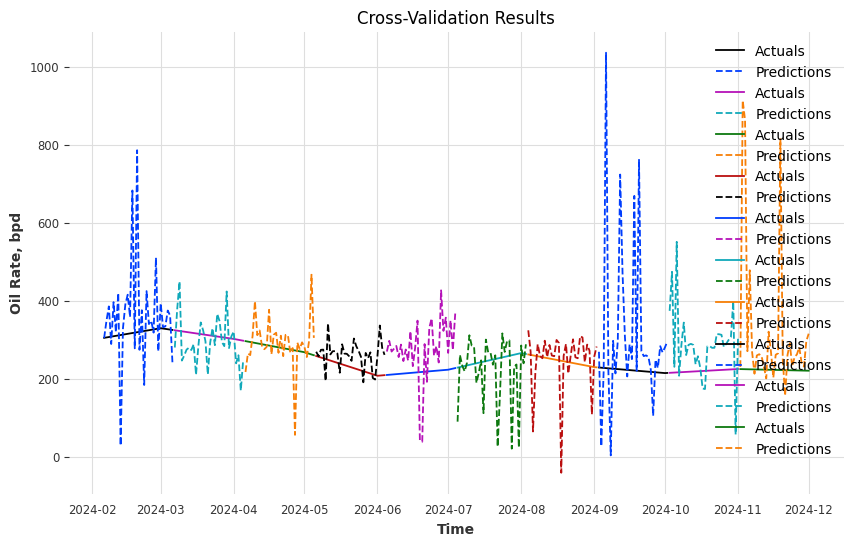

In [38]:
# Set the figure size for the plot
fix, ax = plt.subplots(figsize = (10,6))

# Plot predictions and actual values for each cross-validation fold
for i in range(len(cv)):
  # Get the predictions from the current fold and inverse transform to the original scale
  predictions = TimeSeries.to_series(scaler1.inverse_transform(cv[i]))

  # Extract the corresponding actual values
  start = predictions.index.min()
  end = predictions.index.max()
  actuals = df_well_daily.oil_month_bpd[start:end]

  # Plot the actual values and predictions
  ax.plot(actuals, label="Actuals")
  ax.plot(predictions, label="Predictions", linestyle='dashed')

# Set labels and title for the plot
ax.set_xlabel("Time")
ax.set_ylabel("Oil Rate, bpd")
ax.set_title("Cross-Validation Results")
# Add a legend to the plot
ax.legend()
# Display the plot
plt.show()

# Parameter Tuning

In [39]:
from sklearn.model_selection import ParameterSampler

In [40]:
# Parameter Grid
param_grid = {
    'input_chunk_length': [48,96, 172],
    'output_chunk_length': [24],
    'hidden_size': [8, 16, 24],
    'num_attention_heads': [2,4,6],
    'dropout': [0.1, 0.2, 0.3],
    'batch_size': [32, 64, 128],
    'lstm_layers': [1,2,4],
    'n_epochs': [5,10,20]
}

In [41]:
# Number of parameter combinations to try
n_iter = 10

# Generate a list of parameter combinations to sample from the parameter grid
param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=1502))

# Duplicate the parameter list for further use or comparison
param_list2 = param_list

# Print the list of parameter combinations
print(param_list)

[{'output_chunk_length': 24, 'num_attention_heads': 6, 'n_epochs': 10, 'lstm_layers': 1, 'input_chunk_length': 96, 'hidden_size': 8, 'dropout': 0.1, 'batch_size': 128}, {'output_chunk_length': 24, 'num_attention_heads': 4, 'n_epochs': 10, 'lstm_layers': 1, 'input_chunk_length': 48, 'hidden_size': 24, 'dropout': 0.2, 'batch_size': 64}, {'output_chunk_length': 24, 'num_attention_heads': 4, 'n_epochs': 10, 'lstm_layers': 4, 'input_chunk_length': 96, 'hidden_size': 8, 'dropout': 0.1, 'batch_size': 32}, {'output_chunk_length': 24, 'num_attention_heads': 2, 'n_epochs': 10, 'lstm_layers': 2, 'input_chunk_length': 96, 'hidden_size': 24, 'dropout': 0.2, 'batch_size': 32}, {'output_chunk_length': 24, 'num_attention_heads': 6, 'n_epochs': 20, 'lstm_layers': 1, 'input_chunk_length': 172, 'hidden_size': 24, 'dropout': 0.1, 'batch_size': 64}, {'output_chunk_length': 24, 'num_attention_heads': 4, 'n_epochs': 5, 'lstm_layers': 1, 'input_chunk_length': 96, 'hidden_size': 8, 'dropout': 0.1, 'batch_size'

In [42]:
# Define fixed parameters that will be used across all configurations
fixed_params = {
    'use_static_covariates': True,
    'add_encoders': add_encoders,
    'pl_trainer_kwargs': {'accelerator': 'gpu', "devices": [0]},
}

# Update each parameter set in the list with the fixed parameters
for params in param_list:
  params.update(fixed_params)

In [43]:
# Check the fixed params
param_list

[{'output_chunk_length': 24,
  'num_attention_heads': 6,
  'n_epochs': 10,
  'lstm_layers': 1,
  'input_chunk_length': 96,
  'hidden_size': 8,
  'dropout': 0.1,
  'batch_size': 128,
  'use_static_covariates': True,
  'add_encoders': {'cyclic': {'future': ['hour',
     'day',
     'dayofweek',
     'week',
     'month']},
   'datetime_attribute': {'future': ['hour',
     'day',
     'dayofweek',
     'week',
     'month']},
   'position': {'past': ['relative'], 'future': ['relative']},
   'custom': {'past': [<function __main__.encode_year(idx)>],
    'future': [<function __main__.encode_year(idx)>]},
   'transformer': Scaler,
   'tz': 'CET'},
  'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}},
 {'output_chunk_length': 24,
  'num_attention_heads': 4,
  'n_epochs': 10,
  'lstm_layers': 1,
  'input_chunk_length': 48,
  'hidden_size': 24,
  'dropout': 0.2,
  'batch_size': 64,
  'use_static_covariates': True,
  'add_encoders': {'cyclic': {'future': ['hour',
     'day',
     'dayo

In [44]:
# Initialize a list to store RMSE values for each set of parameters
rmse = []

# Iterate over each set of parameter combinations
for params in param_list:
  # Build the TFT model using the current set of parameters
  model = TFTModel(**params)

  # Perform cross-validation with rolling forecast
  cv = model.historical_forecasts(
      series = y_transformed,
      past_covariates = past_covariates_transformed,
      #future_covariates = future_covariates_transformed,
      forecast_horizon=forecasting_horizon,  # Number of time steps to forecast
      start=df_well_daily.shape[0] - 10 * forecasting_horizon,  # Start point for the rolling forecast
      retrain=True,  # Whether to retrain the model at each step
      stride=forecasting_horizon,  # Number of time steps to move forward for each forecast
      last_points_only=False  # Whether to include only the last points in each rolling window
  )

  # Initialize a list to store RMSE values for each fold
  rmse_cv = []

  # Iterate over each fold in the cross-validation results
  for i in range(len(cv)):
    # Get the predictions from the current fold and inverse transform to the original scale
    predictions = TimeSeries.to_series(scaler1.inverse_transform(cv[i]))

    # Extract the corresponding actual values
    start = predictions.index.min()
    end = predictions.index.max()
    actuals = df_well_daily.oil_month_bpd[start:end]

    # Compute the RMSE for the current fold
    error_cv = np.sqrt(mean_squared_error(actuals, predictions))
    rmse_cv.append(error_cv)

  # Compute the average RMSE for the current set of parameters and append to the list
  rmse.append(np.mean(rmse_cv))

  # Print the parameters tested and the corresponding RMSE
  print(f"Tested parameters: {params} => RMSE {np.mean(rmse_cv)}")

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _Varia

Epoch 9: 100%|██████████| 12/12 [00:01<00:00,  6.65it/s, train_loss=0.950]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 12/12 [00:01<00:00,  6.64it/s, train_loss=0.950]


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      |

Epoch 9: 100%|██████████| 13/13 [00:01<00:00,  6.61it/s, train_loss=0.696]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 13/13 [00:01<00:00,  6.61it/s, train_loss=0.696]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 9.9 K  | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 13/13 [00:01<00:00,  6.63it/s, train_loss=0.681]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 13/13 [00:01<00:00,  6.63it/s, train_loss=0.681]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 9.9 K  | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 13/13 [00:01<00:00,  6.58it/s, train_loss=0.574]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 13/13 [00:01<00:00,  6.58it/s, train_loss=0.574]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 9.9 K  | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 13/13 [00:01<00:00,  6.76it/s, train_loss=0.844]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 13/13 [00:01<00:00,  6.75it/s, train_loss=0.844]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 9.9 K  | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, train_loss=0.423]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, train_loss=0.423]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 9.9 K  | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 14/14 [00:02<00:00,  6.60it/s, train_loss=0.634]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s, train_loss=0.634]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 9.9 K  | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 14/14 [00:02<00:00,  6.17it/s, train_loss=0.991]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 14/14 [00:02<00:00,  6.17it/s, train_loss=0.991]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 9.9 K  | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 14/14 [00:02<00:00,  6.19it/s, train_loss=0.824]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 14/14 [00:02<00:00,  6.19it/s, train_loss=0.824]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 9.9 K  | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 15/15 [00:02<00:00,  6.24it/s, train_loss=0.697]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 15/15 [00:02<00:00,  6.24it/s, train_loss=0.697]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection              

Tested parameters: {'output_chunk_length': 24, 'num_attention_heads': 6, 'n_epochs': 10, 'lstm_layers': 1, 'input_chunk_length': 96, 'hidden_size': 8, 'dropout': 0.1, 'batch_size': 128, 'use_static_covariates': True, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x0000020393EB5800>], 'future': [<function encode_year at 0x0000020393EB5800>]}, 'transformer': Scaler, 'tz': 'CET'}, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE 218.92570846446907
Epoch 9: 100%|██████████| 25/25 [00:04<00:00,  5.11it/s, train_loss=0.389]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 25/25 [00:04<00:00,  5.11it/s, train_loss=0.389]


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      |

Epoch 9: 100%|██████████| 26/26 [00:04<00:00,  5.20it/s, train_loss=0.211]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 26/26 [00:04<00:00,  5.20it/s, train_loss=0.211]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 24.2 K | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 26/26 [00:05<00:00,  5.15it/s, train_loss=0.363]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 26/26 [00:05<00:00,  5.15it/s, train_loss=0.363]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 24.2 K | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 27/27 [00:05<00:00,  5.14it/s, train_loss=0.264]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 27/27 [00:05<00:00,  5.13it/s, train_loss=0.264]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 24.2 K | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 27/27 [00:05<00:00,  5.01it/s, train_loss=0.325]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 27/27 [00:05<00:00,  5.01it/s, train_loss=0.325]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 24.2 K | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 28/28 [00:06<00:00,  4.66it/s, train_loss=0.267]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 28/28 [00:06<00:00,  4.66it/s, train_loss=0.267]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 24.2 K | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 28/28 [00:05<00:00,  5.43it/s, train_loss=0.199]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 28/28 [00:05<00:00,  5.43it/s, train_loss=0.199]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 24.2 K | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 28/28 [00:05<00:00,  5.57it/s, train_loss=0.381]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 28/28 [00:05<00:00,  5.57it/s, train_loss=0.381]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 24.2 K | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 29/29 [00:05<00:00,  5.62it/s, train_loss=0.196]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 29/29 [00:05<00:00,  5.62it/s, train_loss=0.196]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 24.2 K | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 29/29 [00:05<00:00,  5.57it/s, train_loss=0.209]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 29/29 [00:05<00:00,  5.57it/s, train_loss=0.209]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection              

Tested parameters: {'output_chunk_length': 24, 'num_attention_heads': 4, 'n_epochs': 10, 'lstm_layers': 1, 'input_chunk_length': 48, 'hidden_size': 24, 'dropout': 0.2, 'batch_size': 64, 'use_static_covariates': True, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x0000020393EB5800>], 'future': [<function encode_year at 0x0000020393EB5800>]}, 'transformer': Scaler, 'tz': 'CET'}, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE 100.95595710182843
Epoch 9: 100%|██████████| 48/48 [00:08<00:00,  5.81it/s, train_loss=0.319]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 48/48 [00:08<00:00,  5.81it/s, train_loss=0.319]


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      |

Epoch 9: 100%|██████████| 49/49 [00:08<00:00,  5.97it/s, train_loss=0.363]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 49/49 [00:08<00:00,  5.96it/s, train_loss=0.363]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 9.9 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 7.1 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 304    | train
7  | static_cont

Epoch 9: 100%|██████████| 50/50 [00:08<00:00,  5.97it/s, train_loss=0.257]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 50/50 [00:08<00:00,  5.97it/s, train_loss=0.257]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 9.9 K  | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 51/51 [00:08<00:00,  6.02it/s, train_loss=0.251]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 51/51 [00:08<00:00,  6.01it/s, train_loss=0.251]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 9.9 K  | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 52/52 [00:08<00:00,  6.05it/s, train_loss=0.345]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 52/52 [00:08<00:00,  6.05it/s, train_loss=0.345]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 9.9 K  | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 53/53 [00:09<00:00,  5.79it/s, train_loss=0.243]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 53/53 [00:09<00:00,  5.79it/s, train_loss=0.243]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 9.9 K  | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 54/54 [00:08<00:00,  6.07it/s, train_loss=0.339]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 54/54 [00:08<00:00,  6.07it/s, train_loss=0.339]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 9.9 K  | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 55/55 [00:09<00:00,  6.07it/s, train_loss=0.246]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 55/55 [00:09<00:00,  6.07it/s, train_loss=0.246]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 9.9 K  | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 56/56 [00:09<00:00,  5.98it/s, train_loss=0.280]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 56/56 [00:09<00:00,  5.98it/s, train_loss=0.280]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 9.9 K  | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 57/57 [00:09<00:00,  6.15it/s, train_loss=0.245]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 57/57 [00:09<00:00,  6.15it/s, train_loss=0.245]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection              

Tested parameters: {'output_chunk_length': 24, 'num_attention_heads': 4, 'n_epochs': 10, 'lstm_layers': 4, 'input_chunk_length': 96, 'hidden_size': 8, 'dropout': 0.1, 'batch_size': 32, 'use_static_covariates': True, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x0000020393EB5800>], 'future': [<function encode_year at 0x0000020393EB5800>]}, 'transformer': Scaler, 'tz': 'CET'}, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE 103.51912960443565
Epoch 9: 100%|██████████| 48/48 [00:08<00:00,  5.78it/s, train_loss=0.244]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 48/48 [00:08<00:00,  5.78it/s, train_loss=0.244]


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      |

Epoch 9: 100%|██████████| 49/49 [00:08<00:00,  5.79it/s, train_loss=0.207]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 49/49 [00:08<00:00,  5.79it/s, train_loss=0.207]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 24.2 K | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 50/50 [00:08<00:00,  5.62it/s, train_loss=0.215]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 50/50 [00:08<00:00,  5.61it/s, train_loss=0.215]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 24.2 K | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 51/51 [00:08<00:00,  5.79it/s, train_loss=0.236]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 51/51 [00:08<00:00,  5.79it/s, train_loss=0.236]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 24.2 K | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 52/52 [00:09<00:00,  5.77it/s, train_loss=0.237]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 52/52 [00:09<00:00,  5.77it/s, train_loss=0.237]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 24.2 K | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 53/53 [00:09<00:00,  5.72it/s, train_loss=0.132]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 53/53 [00:09<00:00,  5.72it/s, train_loss=0.132]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 24.2 K | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 54/54 [00:09<00:00,  5.79it/s, train_loss=0.201]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 54/54 [00:09<00:00,  5.79it/s, train_loss=0.201]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 24.2 K | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 55/55 [00:09<00:00,  5.74it/s, train_loss=0.179]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 55/55 [00:09<00:00,  5.73it/s, train_loss=0.179]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 24.2 K | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 56/56 [00:09<00:00,  5.73it/s, train_loss=0.148]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 56/56 [00:09<00:00,  5.73it/s, train_loss=0.148]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 24.2 K | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 57/57 [00:09<00:00,  5.74it/s, train_loss=0.275]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 57/57 [00:09<00:00,  5.74it/s, train_loss=0.275]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection              

Tested parameters: {'output_chunk_length': 24, 'num_attention_heads': 2, 'n_epochs': 10, 'lstm_layers': 2, 'input_chunk_length': 96, 'hidden_size': 24, 'dropout': 0.2, 'batch_size': 32, 'use_static_covariates': True, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x0000020393EB5800>], 'future': [<function encode_year at 0x0000020393EB5800>]}, 'transformer': Scaler, 'tz': 'CET'}, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE 67.51587507237848
Epoch 19: 100%|██████████| 23/23 [00:09<00:00,  2.43it/s, train_loss=0.205]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 23/23 [00:09<00:00,  2.43it/s, train_loss=0.205]


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      |

Epoch 19: 100%|██████████| 24/24 [00:09<00:00,  2.48it/s, train_loss=0.170]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 24/24 [00:09<00:00,  2.48it/s, train_loss=0.170]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 24.2 K | train
5  | decoder_vsn                       |

Epoch 19: 100%|██████████| 24/24 [00:09<00:00,  2.48it/s, train_loss=0.155]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 24/24 [00:09<00:00,  2.47it/s, train_loss=0.155]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 24.2 K | train
5  | decoder_vsn                       |

Epoch 19: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s, train_loss=0.104] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s, train_loss=0.104]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 24.2 K | train
5  | decoder_vsn                       |

Epoch 19: 100%|██████████| 25/25 [00:10<00:00,  2.46it/s, train_loss=0.167]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 25/25 [00:10<00:00,  2.46it/s, train_loss=0.167]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 24.2 K | train
5  | decoder_vsn                       |

Epoch 19: 100%|██████████| 26/26 [00:10<00:00,  2.47it/s, train_loss=0.137]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 26/26 [00:10<00:00,  2.47it/s, train_loss=0.137]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 24.2 K | train
5  | decoder_vsn                       |

Epoch 19: 100%|██████████| 26/26 [00:10<00:00,  2.47it/s, train_loss=0.151]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 26/26 [00:10<00:00,  2.47it/s, train_loss=0.151]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 24.2 K | train
5  | decoder_vsn                       |

Epoch 19: 100%|██████████| 27/27 [00:10<00:00,  2.48it/s, train_loss=0.133]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 27/27 [00:10<00:00,  2.48it/s, train_loss=0.133]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 24.2 K | train
5  | decoder_vsn                       |

Epoch 19: 100%|██████████| 27/27 [00:10<00:00,  2.47it/s, train_loss=0.124]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 27/27 [00:10<00:00,  2.47it/s, train_loss=0.124]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 24.2 K | train
5  | decoder_vsn                       |

Epoch 19: 100%|██████████| 27/27 [00:11<00:00,  2.42it/s, train_loss=0.118]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 27/27 [00:11<00:00,  2.42it/s, train_loss=0.118]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection              

Tested parameters: {'output_chunk_length': 24, 'num_attention_heads': 6, 'n_epochs': 20, 'lstm_layers': 1, 'input_chunk_length': 172, 'hidden_size': 24, 'dropout': 0.1, 'batch_size': 64, 'use_static_covariates': True, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x0000020393EB5800>], 'future': [<function encode_year at 0x0000020393EB5800>]}, 'transformer': Scaler, 'tz': 'CET'}, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE 74.14144663690045
Epoch 4: 100%|██████████| 24/24 [00:03<00:00,  6.20it/s, train_loss=0.868]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 24/24 [00:03<00:00,  6.19it/s, train_loss=0.868]


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      |

Epoch 4: 100%|██████████| 25/25 [00:04<00:00,  5.80it/s, train_loss=0.728]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 25/25 [00:04<00:00,  5.80it/s, train_loss=0.728]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 9.9 K  | train
5  | decoder_vsn                       |

Epoch 4: 100%|██████████| 25/25 [00:04<00:00,  6.14it/s, train_loss=0.820]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 25/25 [00:04<00:00,  6.14it/s, train_loss=0.820]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 9.9 K  | train
5  | decoder_vsn                       |

Epoch 4: 100%|██████████| 26/26 [00:04<00:00,  6.17it/s, train_loss=0.726]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 26/26 [00:04<00:00,  6.16it/s, train_loss=0.726]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 9.9 K  | train
5  | decoder_vsn                       |

Epoch 4: 100%|██████████| 26/26 [00:04<00:00,  6.05it/s, train_loss=0.699]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 26/26 [00:04<00:00,  6.05it/s, train_loss=0.699]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 9.9 K  | train
5  | decoder_vsn                       |

Epoch 4: 100%|██████████| 27/27 [00:04<00:00,  6.16it/s, train_loss=0.843]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 27/27 [00:04<00:00,  6.15it/s, train_loss=0.843]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 9.9 K  | train
5  | decoder_vsn                       |

Epoch 4: 100%|██████████| 27/27 [00:04<00:00,  6.16it/s, train_loss=0.896]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 27/27 [00:04<00:00,  6.16it/s, train_loss=0.896]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 9.9 K  | train
5  | decoder_vsn                       |

Epoch 4: 100%|██████████| 28/28 [00:04<00:00,  6.15it/s, train_loss=0.908]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 28/28 [00:04<00:00,  6.15it/s, train_loss=0.908]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 9.9 K  | train
5  | decoder_vsn                       |

Epoch 4: 100%|██████████| 28/28 [00:04<00:00,  6.16it/s, train_loss=0.658]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 28/28 [00:04<00:00,  6.16it/s, train_loss=0.658]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 9.9 K  | train
5  | decoder_vsn                       |

Epoch 4: 100%|██████████| 29/29 [00:04<00:00,  6.17it/s, train_loss=0.560]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 29/29 [00:04<00:00,  6.17it/s, train_loss=0.560]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection              

Tested parameters: {'output_chunk_length': 24, 'num_attention_heads': 4, 'n_epochs': 5, 'lstm_layers': 1, 'input_chunk_length': 96, 'hidden_size': 8, 'dropout': 0.1, 'batch_size': 64, 'use_static_covariates': True, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x0000020393EB5800>], 'future': [<function encode_year at 0x0000020393EB5800>]}, 'transformer': Scaler, 'tz': 'CET'}, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE 261.6213951987689
Epoch 19: 100%|██████████| 48/48 [00:09<00:00,  5.09it/s, train_loss=0.112] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 48/48 [00:09<00:00,  5.09it/s, train_loss=0.112]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 19: 100%|██████████| 49/49 [00:09<00:00,  5.06it/s, train_loss=0.119]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 49/49 [00:09<00:00,  5.06it/s, train_loss=0.119]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 19: 100%|██████████| 50/50 [00:09<00:00,  5.04it/s, train_loss=0.126]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 50/50 [00:09<00:00,  5.04it/s, train_loss=0.126]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 19: 100%|██████████| 51/51 [00:10<00:00,  5.01it/s, train_loss=0.198]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 51/51 [00:10<00:00,  5.01it/s, train_loss=0.198]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 19: 100%|██████████| 52/52 [00:10<00:00,  5.06it/s, train_loss=0.126] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 52/52 [00:10<00:00,  5.06it/s, train_loss=0.126]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 19: 100%|██████████| 53/53 [00:10<00:00,  5.09it/s, train_loss=0.122] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 53/53 [00:10<00:00,  5.09it/s, train_loss=0.122]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 19: 100%|██████████| 54/54 [00:10<00:00,  5.08it/s, train_loss=0.144]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 54/54 [00:10<00:00,  5.08it/s, train_loss=0.144]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 19: 100%|██████████| 55/55 [00:10<00:00,  5.05it/s, train_loss=0.222]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 55/55 [00:10<00:00,  5.05it/s, train_loss=0.222]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 19: 100%|██████████| 56/56 [00:11<00:00,  5.06it/s, train_loss=0.137]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 56/56 [00:11<00:00,  5.06it/s, train_loss=0.137]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 19: 100%|██████████| 57/57 [00:11<00:00,  5.04it/s, train_loss=0.226]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 57/57 [00:11<00:00,  5.04it/s, train_loss=0.226]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection              

Tested parameters: {'output_chunk_length': 24, 'num_attention_heads': 6, 'n_epochs': 20, 'lstm_layers': 4, 'input_chunk_length': 96, 'hidden_size': 16, 'dropout': 0.3, 'batch_size': 32, 'use_static_covariates': True, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x0000020393EB5800>], 'future': [<function encode_year at 0x0000020393EB5800>]}, 'transformer': Scaler, 'tz': 'CET'}, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE 44.42693158408135
Epoch 9: 100%|██████████| 23/23 [00:08<00:00,  2.66it/s, train_loss=0.269]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 23/23 [00:08<00:00,  2.66it/s, train_loss=0.269]


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      |

Epoch 9: 100%|██████████| 24/24 [00:08<00:00,  2.71it/s, train_loss=0.395]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 24/24 [00:08<00:00,  2.71it/s, train_loss=0.395]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 24/24 [00:08<00:00,  2.67it/s, train_loss=0.414]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 24/24 [00:08<00:00,  2.67it/s, train_loss=0.414]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 25/25 [00:09<00:00,  2.67it/s, train_loss=0.294]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 25/25 [00:09<00:00,  2.67it/s, train_loss=0.294]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 25/25 [00:09<00:00,  2.68it/s, train_loss=0.313]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 25/25 [00:09<00:00,  2.68it/s, train_loss=0.313]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 26/26 [00:09<00:00,  2.71it/s, train_loss=0.626]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 26/26 [00:09<00:00,  2.71it/s, train_loss=0.626]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 26/26 [00:09<00:00,  2.70it/s, train_loss=0.287]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 26/26 [00:09<00:00,  2.70it/s, train_loss=0.287]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 27/27 [00:10<00:00,  2.67it/s, train_loss=0.120]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 27/27 [00:10<00:00,  2.67it/s, train_loss=0.120]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 27/27 [00:10<00:00,  2.69it/s, train_loss=0.277]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 27/27 [00:10<00:00,  2.69it/s, train_loss=0.277]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 9: 100%|██████████| 27/27 [00:10<00:00,  2.66it/s, train_loss=0.275]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 27/27 [00:10<00:00,  2.65it/s, train_loss=0.275]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection              

Tested parameters: {'output_chunk_length': 24, 'num_attention_heads': 2, 'n_epochs': 10, 'lstm_layers': 2, 'input_chunk_length': 172, 'hidden_size': 16, 'dropout': 0.2, 'batch_size': 64, 'use_static_covariates': True, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x0000020393EB5800>], 'future': [<function encode_year at 0x0000020393EB5800>]}, 'transformer': Scaler, 'tz': 'CET'}, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE 134.78681237294091
Epoch 19: 100%|██████████| 25/25 [00:03<00:00,  7.45it/s, train_loss=0.251]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 25/25 [00:03<00:00,  7.44it/s, train_loss=0.251]


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      |

Epoch 19: 100%|██████████| 26/26 [00:03<00:00,  7.46it/s, train_loss=0.204]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 26/26 [00:03<00:00,  7.46it/s, train_loss=0.204]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 9.9 K  | train
5  | decoder_vsn                       |

Epoch 19: 100%|██████████| 26/26 [00:03<00:00,  7.42it/s, train_loss=0.240]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 26/26 [00:03<00:00,  7.41it/s, train_loss=0.240]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 9.9 K  | train
5  | decoder_vsn                       |

Epoch 19: 100%|██████████| 27/27 [00:03<00:00,  7.44it/s, train_loss=0.156]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 27/27 [00:03<00:00,  7.43it/s, train_loss=0.156]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 9.9 K  | train
5  | decoder_vsn                       |

Epoch 19: 100%|██████████| 27/27 [00:03<00:00,  7.45it/s, train_loss=0.262]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 27/27 [00:03<00:00,  7.45it/s, train_loss=0.262]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 9.9 K  | train
5  | decoder_vsn                       |

Epoch 19: 100%|██████████| 28/28 [00:03<00:00,  7.49it/s, train_loss=0.342]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 28/28 [00:03<00:00,  7.49it/s, train_loss=0.342]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 9.9 K  | train
5  | decoder_vsn                       |

Epoch 19: 100%|██████████| 28/28 [00:03<00:00,  7.50it/s, train_loss=0.194]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 28/28 [00:03<00:00,  7.50it/s, train_loss=0.194]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 9.9 K  | train
5  | decoder_vsn                       |

Epoch 19: 100%|██████████| 28/28 [00:03<00:00,  7.52it/s, train_loss=0.249]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 28/28 [00:03<00:00,  7.51it/s, train_loss=0.249]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 9.9 K  | train
5  | decoder_vsn                       |

Epoch 19: 100%|██████████| 29/29 [00:04<00:00,  7.00it/s, train_loss=0.239]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 29/29 [00:04<00:00,  7.00it/s, train_loss=0.239]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 9.9 K  | train
5  | decoder_vsn                       |

Epoch 19: 100%|██████████| 29/29 [00:04<00:00,  7.17it/s, train_loss=0.219]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 29/29 [00:04<00:00,  7.17it/s, train_loss=0.219]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Tested parameters: {'output_chunk_length': 24, 'num_attention_heads': 4, 'n_epochs': 20, 'lstm_layers': 1, 'input_chunk_length': 48, 'hidden_size': 8, 'dropout': 0.2, 'batch_size': 64, 'use_static_covariates': True, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x0000020393EB5800>], 'future': [<function encode_year at 0x0000020393EB5800>]}, 'transformer': Scaler, 'tz': 'CET'}, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE 94.88625186675806



   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 12.4 K | train
6  | static_context_grn                | _GatedResidualNetwork            | 1.1 K  | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 1.1 K  | train
8  | static_context_cell_encoder_grn   | _GatedResidualNetwork            | 1.1 K  

Epoch 19: 100%|██████████| 48/48 [00:08<00:00,  5.59it/s, train_loss=0.130]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 48/48 [00:08<00:00,  5.58it/s, train_loss=0.130]


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      |

Epoch 19: 100%|██████████| 49/49 [00:08<00:00,  5.65it/s, train_loss=0.185]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 49/49 [00:08<00:00,  5.64it/s, train_loss=0.185]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 19: 100%|██████████| 50/50 [00:08<00:00,  5.57it/s, train_loss=0.120]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 50/50 [00:08<00:00,  5.57it/s, train_loss=0.120]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 19: 100%|██████████| 51/51 [00:09<00:00,  5.61it/s, train_loss=0.089] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 51/51 [00:09<00:00,  5.61it/s, train_loss=0.089]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 19: 100%|██████████| 52/52 [00:09<00:00,  5.63it/s, train_loss=0.214]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 52/52 [00:09<00:00,  5.63it/s, train_loss=0.214]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 19: 100%|██████████| 53/53 [00:09<00:00,  5.60it/s, train_loss=0.353]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 53/53 [00:09<00:00,  5.60it/s, train_loss=0.353]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 19: 100%|██████████| 54/54 [00:09<00:00,  5.68it/s, train_loss=0.265]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 54/54 [00:09<00:00,  5.67it/s, train_loss=0.265]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 19: 100%|██████████| 55/55 [00:09<00:00,  5.65it/s, train_loss=0.133]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 55/55 [00:09<00:00,  5.65it/s, train_loss=0.133]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 19: 100%|██████████| 56/56 [00:09<00:00,  5.65it/s, train_loss=0.111] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 56/56 [00:09<00:00,  5.65it/s, train_loss=0.111]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       |

Epoch 19: 100%|██████████| 57/57 [00:10<00:00,  5.54it/s, train_loss=0.0997]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 57/57 [00:10<00:00,  5.54it/s, train_loss=0.0997]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Tested parameters: {'output_chunk_length': 24, 'num_attention_heads': 6, 'n_epochs': 20, 'lstm_layers': 2, 'input_chunk_length': 96, 'hidden_size': 16, 'dropout': 0.2, 'batch_size': 32, 'use_static_covariates': True, 'add_encoders': {'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x0000020393EB5800>], 'future': [<function encode_year at 0x0000020393EB5800>]}, 'transformer': Scaler, 'tz': 'CET'}, 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}} => RMSE 54.431223971197404


In [45]:
# Create a DataFrame and add the RMSE values
results_df = pd.DataFrame(param_list2)
results_df['rmse'] = rmse
results_df

,output_chunk_length,num_attention_heads,n_epochs,lstm_layers,input_chunk_length,hidden_size,dropout,batch_size,use_static_covariates,add_encoders,pl_trainer_kwargs,rmse
0,24,6,10,1,96,8,0.1,128,True,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...","{'accelerator': 'gpu', 'devices': [0]}",218.925708
1,24,4,10,1,48,24,0.2,64,True,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...","{'accelerator': 'gpu', 'devices': [0]}",100.955957
2,24,4,10,4,96,8,0.1,32,True,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...","{'accelerator': 'gpu', 'devices': [0]}",103.519130
3,24,2,10,2,96,24,0.2,32,True,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...","{'accelerator': 'gpu', 'devices': [0]}",67.515875
4,24,6,20,1,172,24,0.1,64,True,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...","{'accelerator': 'gpu', 'devices': [0]}",74.141447
5,24,4,5,1,96,8,0.1,64,True,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...","{'accelerator': 'gpu', 'devices': [0]}",261.621395
6,24,6,20,4,96,16,0.3,32,True,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...","{'accelerator': 'gpu', 'devices': [0]}",44.426932
7,24,2,10,2,172,16,0.2,64,True,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...","{'accelerator': 'gpu', 'devices': [0]}",134.786812
8,24,4,20,1,48,8,0.2,64,True,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...","{'accelerator': 'gpu', 'devices': [0]}",94.886252
9,24,6,20,2,96,16,0.2,32,True,"{'cyclic': {'future': ['hour', 'day', 'dayofwe...","{'accelerator': 'gpu', 'devices': [0]}",54.431224


In [46]:
# Identify the parameter set(s) with the lowest RMSE and export it to a CSV file
best_params = results_df[results_df['rmse'] == results_df['rmse'].min()]
best_params.to_csv('Deep Learning for Time Series Forecasting/TFT/data/vm/vm_best_params.csv')

# Predict the Future

In [47]:
# Load the best parameters from the CSV file, and put it in a dictionary
best_params = pd.read_csv('Deep Learning for Time Series Forecasting/TFT/data/vm/vm_best_params.csv', index_col =0).drop(columns = "rmse")
best_params_dict = best_params.squeeze().to_dict()
best_params_dict

{'output_chunk_length': 24,
 'num_attention_heads': 6,
 'n_epochs': 20,
 'lstm_layers': 4,
 'input_chunk_length': 96,
 'hidden_size': 16,
 'dropout': 0.3,
 'batch_size': 32,
 'use_static_covariates': True,
 'add_encoders': "{'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x0000020393EB5800>], 'future': [<function encode_year at 0x0000020393EB5800>]}, 'transformer': Scaler, 'tz': 'CET'}",
 'pl_trainer_kwargs': "{'accelerator': 'gpu', 'devices': [0]}"}

In [48]:
# List of parameters that should be converted to integers
int_params = ['input_chunk_length', 'output_chunk_length',
              'hidden_size', 'num_attention_heads', 'batch_size',
              'lstm_layers', 'n_epochs']

# Convert specified float parameters to integers
for key in int_params:
  best_params_dict[key] = int(best_params_dict[key])

In [49]:
# Update the best parameters dictionary with the fixed parameters
best_params_dict.update(fixed_params)
best_params_dict

{'output_chunk_length': 24,
 'num_attention_heads': 6,
 'n_epochs': 20,
 'lstm_layers': 4,
 'input_chunk_length': 96,
 'hidden_size': 16,
 'dropout': 0.3,
 'batch_size': 32,
 'use_static_covariates': True,
 'add_encoders': {'cyclic': {'future': ['hour',
    'day',
    'dayofweek',
    'week',
    'month']},
  'datetime_attribute': {'future': ['hour',
    'day',
    'dayofweek',
    'week',
    'month']},
  'position': {'past': ['relative'], 'future': ['relative']},
  'custom': {'past': [<function __main__.encode_year(idx)>],
   'future': [<function __main__.encode_year(idx)>]},
  'transformer': Scaler,
  'tz': 'CET'},
 'pl_trainer_kwargs': {'accelerator': 'gpu', 'devices': [0]}}

In [50]:
# Build the TFT model using the best-tuned parameters
tuned_model = TFTModel(**best_params_dict)

# Fit the tuned model
tuned_model.fit(y_transformed,
                past_covariates = past_covariates_transformed,
                #future_covariates = future_covariates_transformed
                )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.2 K | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 12.4 K | train
6  | static_context_grn                | _GatedResidualNetwork            | 1.1 K  | train
7  | static_cont

Epoch 19: 100%|██████████| 58/58 [00:11<00:00,  5.02it/s, train_loss=0.103]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 58/58 [00:11<00:00,  5.02it/s, train_loss=0.103]


TFTModel(output_chunk_shift=0, hidden_size=16, lstm_layers=4, num_attention_heads=6, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.3, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, output_chunk_length=24, n_epochs=20, input_chunk_length=96, batch_size=32, add_encoders={'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x0000020393EB5800>], 'future': [<function encode_year at 0x0000020393EB5800>]}, 'transformer': Scaler, 'tz': 'CET'}, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]})

In [51]:
# Generate forecasts for the future using the tuned model
forecast = tuned_model.predict(n = forecasting_horizon,
                               series = y_transformed,
                               past_covariates = past_covariates_transformed,
                               #future_covariates = #future_covariates_transformed
                               )

# Inverse transform the forecasted values to the original scale and rename the series
forecast = TimeSeries.to_series(scaler1.inverse_transform(forecast)).rename("TFT")
# Display the forecasted values
forecast

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
ValueError: For the given forecasting horizon `n=30`, the provided `past_covariates` at series sequence index `0` do not extend far enough into the future. As `n > output_chunk_length` the `past_covariates` must end at or after time step `2024-12-07 00:00:00`, whereas now the end is at time step `2024-12-01 00:00:00`.


ValueError: For the given forecasting horizon `n=30`, the provided `past_covariates` at series sequence index `0` do not extend far enough into the future. As `n > output_chunk_length` the `past_covariates` must end at or after time step `2024-12-07 00:00:00`, whereas now the end is at time step `2024-12-01 00:00:00`.

In [ ]:
# Plot the forecasted values along with actual data

# Set figure size
fig, ax = plt.subplots(figsize = (10,6))
# Plot actual values from December 2017 onwards
ax.plot(df_well_daily.oil_month_bpd['2017-12':], label = "actuals")
# Plot forecasted values with a dashed line
ax.plot(forecast, label = "forecast", linestyle = 'dashed')

# Set labels, title, and legend for the plot
ax.set_xlabel("Time")
ax.set_ylabel("Oil Production Rate, bpd")
ax.set_title("TFT Forecast")
ax.legend()
plt.show()

# Interpretability

In [ ]:
from darts.explainability import TFTExplainer

In [ ]:
# Build the explainer for the tuned TFT model
explainer = TFTExplainer(tuned_model)
# Generate explainability results for the model
explainability_result = explainer.explain()

In [ ]:
# Plot the variable importance based on the explainability results
explainer.plot_variable_selection(explainability_result, fig_size = (15,15))

In [ ]:
# Plot the attention mechanism for the model
explainer.plot_attention(explainability_result, plot_type = "time")